In [1]:
#import libraries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy import ndimage, misc
import cv2
from skimage.morphology import skeletonize
from fil_finder import FilFinder2D
import astropy.units as u
import gc
import sklearn.metrics
import timeit
from scipy.interpolate import CubicSpline
gc.collect()
import sys

np.set_printoptions(threshold=False)

C:\Users\heito\Desktop\Harvard\Sharad Lab\G1\Random_12


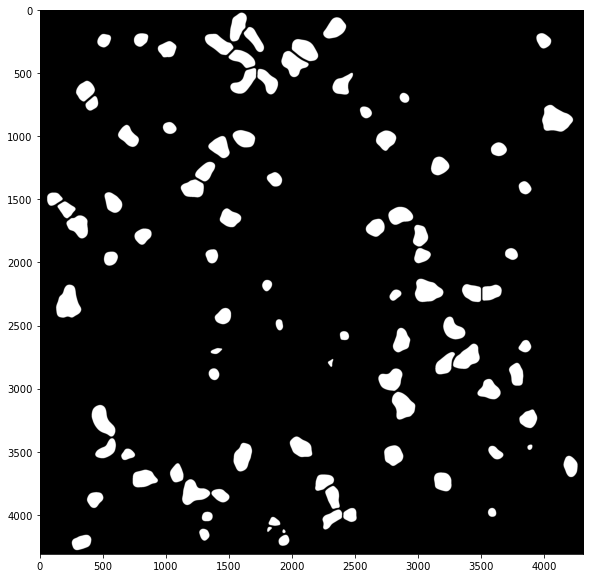

In [191]:
#insert path where images are located
%cd C:\Users\heito\Desktop\Harvard\Sharad Lab\G1\Random_12 
#import images    
img =cv2.imread('final_random_12_masks.tif',1) #segmented and eroded image (normally from DAPI stain)
img_gene1=cv2.imread('final_random_12_gene1.tif',0) #image of CDX2 gene expression
img_gene2=cv2.imread('final_random_12_gene2.tif',0) #image of SOX1 gene expression
img_gene3=cv2.imread('final_random_12_gene3.tif',0)
plt.figure(figsize=(10,10))
plt.imshow(img)

In [136]:
%cd C:\Users\heito\Desktop\Harvard\Sharad Lab\G1\combined_random
expNums = [3,4,7,8,11,12]
gene1_f_Names = []
gene2_f_Names = []
mask_f_Names=[]
for num in expNums:
    mask_f_Names.append('final_random_' + str(num) + '_masks.tif')
    gene1_f_Names.append('final_random_' + str(num) + '_gene1.tif')
    gene2_f_Names.append('final_random_' + str(num) + '_gene2.tif')
intensities_gene1 = []
intensities_gene2 = []
intensities_mask = []
for f in gene1_f_Names:
    img_gene1 = cv2.imread(f, 0)
    intensities_gene1.append(img_gene1.flatten())
for f in gene2_f_Names:
    img_gene2 = cv2.imread(f, 0)
    intensities_gene2.append(img_gene2.flatten())
for f in mask_f_Names:
    img = cv2.imread(f)
    intensities_mask.append(img[:,:,1].flatten())

C:\Users\heito\Desktop\Harvard\Sharad Lab\G1\combined_random


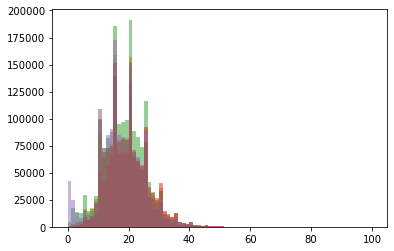

In [163]:
for ii in range(np.shape(intensities_mask)[0]):
    a=np.where(intensities_mask[ii]==255)
    b=intensities_gene1[ii]
    c=b[a]
    plt.hist(c,80,alpha=0.5,range=(0,100))
cut1=np.quantile(c,0.9999)

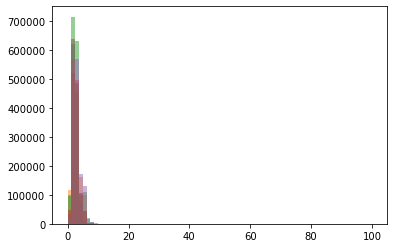

In [164]:
for ii in range(np.shape(intensities_mask)[0]):
    a=np.where(intensities_mask[ii]==255)
    b=intensities_gene2[ii]
    c=b[a]
    plt.hist(c,80,alpha=0.5,range=(0,100))
cut2=np.quantile(c,0.9999)

In [192]:
img_gene1=np.where(img_gene1<cut1,img_gene1, cut1)
img_gene2=np.where(img_gene2<cut2,img_gene2, cut2)

img_gene1=(img_gene1-np.min(img_gene1))/(np.max(img_gene1)-np.min(img_gene1))
img_gene2=(img_gene2-np.min(img_gene2))/(np.max(img_gene2)-np.min(img_gene2))


(0.0, 1000000.0)

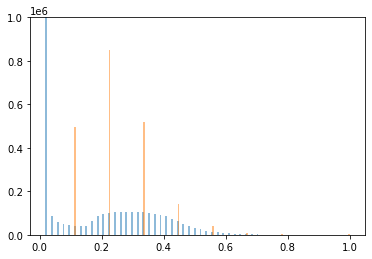

In [193]:
flat=np.ndarray.flatten(img_gene1)
flat = flat.astype('float')
flat[flat==0]=np.nan
plt.hist(flat,160,alpha=0.5)
flat=np.ndarray.flatten(img_gene2)
flat = flat.astype('float')
flat[flat==0]=np.nan
plt.hist(flat,160,alpha=0.5)

plt.ylim(0, 1*10**6)

In [174]:
def get_intersection(hey,initial_pos,epsilon,contour): #function that finds the intersection points and also returns sides of region(normal line)
    # hey contains the points of the skeleton
    x_vec=hey[:,0]
    y_vec=hey[:,1]
    # find line across points of the skeleton centered on initial_pos and +- epsilon
    fit=np.polyfit(x=x_vec[initial_pos-epsilon:initial_pos+epsilon], y=y_vec[initial_pos-epsilon:initial_pos+epsilon], deg=1)
    # find contants of normal line
    m_normal=-1/fit[0]
    b_normal=y_vec[initial_pos]-(m_normal*x_vec[initial_pos])
    
    # if line is too steep, draw straight line and fill in betweens
    if abs(m_normal)>1000:
        y_list=np.linspace(y_vec[initial_pos]-500,y_vec[initial_pos]+500,1500000)
        x_list=np.repeat(x_vec[initial_pos], np.shape(y_list)[0])
        y_list = [int(x) for x in y_list]
        x_list=[int(x) for x in x_list]
    else:
        x_list=np.linspace(x_vec[initial_pos]-500,x_vec[initial_pos]+500,1500000)
        y_list=m_normal*x_list+b_normal
        y_list = [int(x) for x in y_list]
        x_list=[int(x) for x in x_list]
    
    coord_list=list(zip(y_list, x_list))
    arr2_3=np.array(coord_list)
    arr1=np.squeeze(contour)
    #print(arr2_3)
    
    indexes = np.unique(arr2_3, return_index=True,axis=0)[1]
    arr2_2=np.squeeze([arr2_3[index] for index in sorted(indexes)])
   # print(arr2_2)
    # if points are diagonal, fill in so that points are always 1 away in any direction (makes sure there will be an intersection with contour)
    for hh in range(np.shape(arr2_2)[0]-1):
        if arr2_2[hh+1,0]==arr2_2[hh,0]+1 and arr2_2[hh+1,1]==arr2_2[hh,1]+1:
            temp=np.append(arr2_2[0:hh+1,:],[arr2_2[hh,:]+[1,0]],axis=0)
            arr2_2=np.append(temp,arr2_2[hh+1:],axis=0)
        if arr2_2[hh+1,0]==arr2_2[hh,0]-1 and arr2_2[hh+1,1]==arr2_2[hh,1]+1:
            temp=np.append(arr2_2[0:hh+1,:],[arr2_2[hh,:]-[1,0]],axis=0)
            arr2_2=np.append(temp,arr2_2[hh+1:],axis=0)
        if arr2_2[hh+1,0]==arr2_2[hh,0]+1 and arr2_2[hh+1,1]==arr2_2[hh,1]-1:
            temp=np.append(arr2_2[0:hh+1,:],[arr2_2[hh,:]+[1,0]],axis=0)
            arr2_2=np.append(temp,arr2_2[hh+1:],axis=0)
        if arr2_2[hh+1,0]==arr2_2[hh,0]-1 and arr2_2[hh+1,1]==arr2_2[hh,1]-1:
            temp=np.append(arr2_2[0:hh+1,:],[arr2_2[hh,:]-[1,0]],axis=0)
            arr2_2=np.append(temp,arr2_2[hh+1:],axis=0)
            
    
    
    
    intersection=np.array([x for x in set(tuple(x) for x in arr2_2) & set(tuple(x) for x in arr1)])

    #if less than 2 points are found, run again with contour expanded by one (very rare case)
    
    #find better way
    if np.shape(intersection)[0]<2:
        arr1=np.concatenate((arr1,arr1+1),axis=0)
      
        intersection=np.array([x for x in set(tuple(x) for x in arr2_2) & set(tuple(x) for x in arr1)])
        #print(intersection)
    #if more than 2 intersection points, eliminate duplicates (two points super close to each other) and select closest points to skeleton 
    if np.shape(intersection)[0]>2: #fix this make more general
        dist_1=sklearn.metrics.pairwise_distances(intersection)
        np.fill_diagonal(dist_1, 100)
        dist_1=np.tril(dist_1, k=0)
        dist_1[dist_1==0]=100
        a=np.where(dist_1<5)
        mid_point=np.delete(intersection, a[0][:],0)
        intersection=mid_point
        if np.shape(mid_point)[0]>2:
            repe=np.repeat([[y_vec[initial_pos],x_vec[initial_pos]]],np.shape(mid_point)[0], axis=0)
            dist=np.sqrt((mid_point[:,0]-repe[:,0])**2+(mid_point[:,1]-repe[:,1])**2)
            mins=np.partition(dist,2)[0:2]
            min_id1=np.where(dist==mins[0])
            min_id2=np.where(dist==mins[1])
            intersection=mid_point[[min_id1[0][0],min_id2[0][0]],:]
    #print(intersection)   
    id1=np.where((arr2_2[:,1]==intersection[0,1]) & (arr2_2[:,0]==intersection[0,0]))
    id2=np.where((arr2_2[:,1]==intersection[1,1]) & (arr2_2[:,0]==intersection[1,0]))
    id_min=np.min([id1[0][0],id2[0][0]])
    id_max=np.max([id1[0][0],id2[0][0]])
    side=coord_list[id_min:id_max]
    
    edge1=np.where((arr1[:,1]==intersection[0,1]) & (arr1[:,0]==intersection[0,0]))
    edge2=np.where((arr1[:,1]==intersection[1,1]) & (arr1[:,0]==intersection[1,0]))
    
    return side, edge1, edge2, arr1

In [175]:
def get_gene_dipole(hey,contour,epsilon,img_gene1,img_gene2): #function that separates organoids into sections and returns gene dipole
    jj=0
    
    #n_segments=20 #number of segments
    #epsilon=np.shape(hey)[0]//n_segments
    
    epsilon=epsilon
    n_segments=np.shape(hey)[0]//epsilon
    initial_pos=epsilon
    gene1=np.empty([1,0])
    gene2=np.empty([1,0])
    position=np.empty([1,0])
    
    # if organoid only has two section aka small skeleton
    if initial_pos+epsilon>(np.shape(hey)[0]):
        mid_point=np.shape(hey)[0]//2
        eps=mid_point-1
        side1, edge1, edge2, arr1 = get_intersection(hey,mid_point,eps,contour)
        edges=np.sort([edge1[0][0],edge2[0][0]])
        
        #first half
        if edges[0]==edges[1]:
            edges[1]=edges[1]+1
        
        line1=arr1[edges[0]:edges[1]]
    
        if np.sum(line1[0,:]-line1[-1,:]) <0:
            line1=np.flip(line1,0)
        region_cont=np.concatenate((line1,side1))
        im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image 
        filled_array = cv2.fillPoly(im_zer, pts =[region_cont], color=(255))

        region = np.argwhere(filled_array == 255)
        #plt.plot(region[:,0],region[:,1],'bo')
        
        segment=np.squeeze(img_gene1[:,:])*filled_array
        segment[segment == 0] = np.nan
        gene1=np.append(gene1, np.nanmean(segment)/255)
        segment=np.squeeze(img_gene2[:,:])*filled_array
        segment[segment == 0] = np.nan
        gene2=np.append(gene2, np.nanmean(segment)/255)
        position=np.append(position, mid_point-eps/2)
        
         
    
        # second half
        if edges[0]==edges[1]:
            edges[1]=edges[1]+1
        
        line1=np.concatenate((arr1[edges[1]:-1],arr1[0:edges[0]]))
    
        if np.sum(line1[0,:]-line1[-1,:]) <0:
            line1=np.flip(line1,0)
        region_cont=np.concatenate((line1,side1))
        im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image 
        filled_array = cv2.fillPoly(im_zer, pts =[region_cont], color=(255))

        region = np.argwhere(filled_array == 255)
        
        region = np.argwhere(filled_array == 255)
        #plt.plot(region[:,0],region[:,1],'ro')
        #plt.show()
        segment=np.squeeze(img_gene1[:,:])*filled_array
        segment[segment == 0] = np.nan
        gene1=np.append(gene1, np.nanmean(segment)/255)
        segment=np.squeeze(img_gene2[:,:])*filled_array
        segment[segment == 0] = np.nan
        gene2=np.append(gene2, np.nanmean(segment)/255)
        position=np.append(position, mid_point+eps/2)
       
         
        if np.shape(gene1)[0]==1:
            area_red=gene1[0]
            area_blue=gene2[0]
        else:
            area_red = np.trapz(gene1/np.max(gene1), dx=position[1]-position[0])
            area_blue = np.trapz(gene2/np.max(gene1), dx=position[1]-position[0])
        
        dipole=area_red/(area_red+area_blue)
    
    
    #long skeleton organoid
    n=0
    while (initial_pos+epsilon)<(np.shape(hey)[0]): #iterate through every point on skeleton to get normal lines
        #first section (fix path,sometimes wrong, take shortest path?)
        if n==0:
            mid_point=initial_pos
            eps=epsilon
            side1, edge1, edge2, arr1 = get_intersection(hey,mid_point,eps,contour)
            edges=np.sort([edge1[0][0],edge2[0][0]])
            
            if edges[0]==edges[1]:
                edges[1]=edges[1]+1
        
            #line1=arr1[edges[0]:edges[1]]
            path1=np.concatenate((arr1[edges[1]:-1],arr1[0:edges[0]]))
            path2=arr1[edges[0]:edges[1]]
            if np.shape(path1)[0]>np.shape(path2)[0]:
                line1=path2
            else:
                line1=path1
            
            if np.sum(line1[0,:]-line1[-1,:]) <0:
                line1=np.flip(line1,0)
            region_cont=np.concatenate((line1,side1))
            im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image 
            filled_array = cv2.fillPoly(im_zer, pts =[region_cont], color=(255))

            region = np.argwhere(filled_array == 255)
            #plt.plot(region[:,0],region[:,1],'go')
            
            segment=np.squeeze(img_gene1[:,:])*filled_array
            segment[segment == 0] = np.nan
            gene1=np.append(gene1, np.nanmean(segment)/255)
            segment=np.squeeze(img_gene2[:,:])*filled_array
            segment[segment == 0] = np.nan
            gene2=np.append(gene2, np.nanmean(segment)/255)
            position=np.append(position, mid_point-eps/2)  
            
        
        n=n+1
        side1, edge1, edge2, arr1 = get_intersection(hey,initial_pos,epsilon,contour)
       
        #edge_min_1=np.min([edge1,edge2])
        #edge_max_2=np.max([edge1,edge2])
    
        
        
        
        initial_pos=initial_pos+epsilon
        
        
        side2, edge3, edge4, arr1_1 = get_intersection(hey,initial_pos,epsilon,contour)
        #temp fix
        if np.size(arr1_1)>np.size(arr1):
            arr1=arr1_1
        
       
        #edge_min_3=np.min([edge3,edge4])
        #edge_max_4=np.max([edge3,edge4])
        edges=np.sort([edge1[0][0],edge2[0][0],edge3[0][0],edge4[0][0]])
        if edges[0]==edges[1]:
            edges[1]=edges[1]+1
        if edges[2]==edges[3]:
            edges[3]=edges[3]+1
        path1=np.concatenate((arr1[edges[1]:-1],arr1[0:edges[0]]))
        path2=arr1[edges[0]:edges[1]]
        if np.shape(path2)[0]>np.shape(path1)[0]:
            line1=path1
        else:
            line1=path2
        path1=np.concatenate((arr1[edges[3]:-1],arr1[0:edges[2]]))
        path2=arr1[edges[2]:edges[3]]
        
        if np.shape(path2)[0]>np.shape(path1)[0]:
            line2=path1
        else:
            line2=path2
            
            
        #line1=arr1[edges[0]:edges[1]]
        #line2=arr1[edges[2]:edges[3]]
        
        if np.sum(line1[0,:]-line1[-1,:]) <0:
            line1=np.flip(line1,0)
        
        if np.sum(line2[0,:]-line2[-1,:]) >0:
            
            line2=np.flip(line2,0)
        side2=np.flip(side2,0)
        region_cont=np.concatenate((line1,side1,line2,side2))
        side_cross=np.array([x for x in set(tuple(x) for x in side1) & set(tuple(x) for x in side2)])
        if np.shape(side_cross)[0]>0:
            line1=np.flip(line1,0)
            line2=np.flip(line2,0)
        im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image 
        filled_array = cv2.fillPoly(im_zer, pts =[region_cont], color=(255))

        region = np.argwhere(filled_array == 255)
        segment=np.squeeze(img_gene1[:,:])*filled_array
        segment[segment == 0] = np.nan
        #plt.imshow(segment)
        gene1=np.append(gene1, np.nanmean(segment)/255)
        segment=np.squeeze(img_gene2[:,:])*filled_array
        segment[segment == 0] = np.nan
        gene2=np.append(gene2, np.nanmean(segment)/255)
        position=np.append(position, initial_pos-epsilon/2)
        initial_pos=initial_pos
        #plt.imshow(segment)
        #plt.axis([3800,4200,1300,1700])
        #plt.pause(0.05)
        
        #last section
        if n==n_segments-1:
            mid_point=initial_pos-epsilon//4
            eps=epsilon//4
            side1, edge1, edge2, arr1 = get_intersection(hey,mid_point,eps,contour)
            edges=np.sort([edge1[0][0],edge2[0][0]])
            
            if edges[0]==edges[1]:
                edges[1]=edges[1]+1
        
            path1=np.concatenate((arr1[edges[1]:-1],arr1[0:edges[0]]))
            path2=arr1[edges[0]:edges[1]]
            if np.shape(path2)[0]>np.shape(path1)[0]:
                line1=path1
            else:
                line1=path2
    
            if np.sum(line1[0,:]-line1[-1,:]) <0:
                line1=np.flip(line1,0)
            region_cont=np.concatenate((line1,side1))
            im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image 
            filled_array = cv2.fillPoly(im_zer, pts =[region_cont], color=(255))
            filled_array[filled_array == 0] = np.nan
            region = np.argwhere(filled_array == 255)
            
            segment=np.squeeze(img_gene1[:,:])*filled_array
            
            gene1=np.append(gene1, np.nanmean(segment)/255)
            segment=np.squeeze(img_gene2[:,:])*filled_array
            
            gene2=np.append(gene2, np.nanmean(segment)/255)
            position=np.append(position, mid_point-eps/2)
             
    
    #gene_1_mean=np.mean(np.squeeze(img_gene1[:,:,0]))/np.max(gene1)
    #gene_2_mean=np.mean(np.squeeze(img_gene2[:,:,0]))/np.max(gene2)
    
   # print(dip_1)
    #print(dip_2)
    
    if np.shape(gene1)[0]==1:
        dip_1=0
        dip_2=0    
        dipole=np.abs(np.sum(dip_1)-np.sum(dip_2))/(np.shape(hey)[0]/2)
    else:
        #area_red = np.trapz(gene1/np.max(gene1), dx=position[1]-position[0])
        #area_blue = np.trapz(gene2/np.max(gene1), dx=position[1]-position[0])
        dip_1=gene1*(position-np.shape(hey)[0]/2)#/np.max(np.squeeze(img_gene1[:,:,0]))
        dip_2=gene2*(position-np.shape(hey)[0]/2)#/np.max(np.squeeze(img_gene2[:,:,0])) 
        #dip_2=0
        dipole=np.abs(np.sum(dip_1)-np.sum(dip_2))/(np.shape(hey)[0]/2)
        
        #if np.max(gene1/np.max(np.squeeze(img_gene1[:,:,0])))<0.03 or np.max(gene2)/np.max(np.squeeze(img_gene2[:,:,0]))<0.03:
         #   dipole=np.array([0])
        #print(gene1/np.max(np.squeeze(img_gene1[:,:,0])))
        #print(gene2/np.max(np.squeeze(img_gene2[:,:,0])))
        #print(position)
        #dipole=np.abs(np.sum(dip_1))/(np.shape(hey)[0]/2)
    #yp=np.linspace(0, 1, 1000)
    #plt.plot(position, gene1/np.max(gene1),'r.')
    #plt.plot(position, gene2/np.max(gene2),'b.')
    #plt.plot(yp,fit_1(yp),'r--')
    #plt.plot(yp,fit_2(yp),'b--')
    #plt.axis([0, position[-1]+50, 0, 1])
    #plt.show()
    if dipole.size == 0:
        dipole=0
    return dipole

In [194]:

# Grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find Canny edges
edged = cv2.Canny(img, 30, 200)

#Find contours
contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

#Initialize arrays
start = timeit.timeit()
dipole_list=np.empty([1,0])
elongation_list=np.empty([1,0])
aspect_ratio_list=np.empty([1,0])
meso_list=np.empty([1,0])
centroid_list=[[1,1], [1,1]]
true_org=np.empty([1,0])
mean_m_list=np.empty([1,0])

#Check if contours are organoids
for ii in range(np.shape(contours)[0]):
    
    M = cv2.moments(contours[ii])
    if M["m00"] == 0:
        true_org=np.append(true_org,0)
    else:
        true_org=np.append(true_org,1)


for ii in range(np.shape(contours)[0]):
    
    if true_org[ii]==1:
        im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image 
        filled_array = cv2.fillPoly(im_zer, pts =[contours[ii]], color=(255))
        
        # diff of mean intensity 
        filled_array[filled_array == 0] = np.nan
        segment=np.squeeze(img_gene1[:,:])*filled_array
        mean1=np.nanmean(segment)/(255*np.max(np.squeeze(img_gene1[:,:])))
        
        segment=np.squeeze(img_gene2[:,:])*filled_array
        mean2=np.nanmean(segment)/(255*np.max(np.squeeze(img_gene2[:,:])))
        
        meanm=mean1-mean2
        
        obj = np.argwhere(filled_array == 255)
        
        # average mesoderm intensity
        meso=np.nanmean(filled_array*np.squeeze(img_gene3[:,:])/np.max(np.squeeze(img_gene3[:,:])))
        

        bin_arr = np.where(filled_array > 0, 1, 0)
    
        image = bin_arr

    # perform skeletonization
    
        skeleton1 = skeletonize(image)


        binSkel = skeleton1*1
        skelObj = np.argwhere(binSkel == 1)

        fil = FilFinder2D(binSkel, distance=250 * u.pc, mask=skeleton1)
        fil.preprocess_image(flatten_percent=85)
        fil.create_mask(border_masking=True, verbose=False,
        use_existing_mask=True)
        fil.medskel(verbose=False)
        fil.analyze_skeletons(branch_thresh=40* u.pix, skel_thresh=5 * u.pix, prune_criteria='length')
        skeleton_length=fil.lengths()
        # how many tails the organoid has
        numb=fil.branch_properties['number']
        
        

        # find aspect ratio
        x,y,w,h = cv2.boundingRect(contours[ii])
        aspect_ratio = float(w)/h
        # find centroid
        M = cv2.moments(contours[ii])
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centroid=np.array([cY,cX])
        
        # order skeleton
        hey_1 = np.argwhere(fil.skeleton_longpath==1)
        if hey_1.size==0:
            hey_1=skelObj
        im_zer = np.zeros( (img.shape[0],img.shape[1]) )
        skele_im=im_zer
        skele_im[hey_1[:,0],hey_1[:,1]]=255
        n=0
        ma=np.array([1,1,1])
        ok2=0
        while ok2==0:
            
            in_x=hey_1[n,0]
            in_y=hey_1[n,1]
            ma=skele_im[in_x-1:in_x+2,in_y-1:in_y+2]
            n=n+1
            if np.sum(ma)<255*3:
                ok2=1
        skeleton=np.array([[0,1],[in_x, in_y]])
        ok=0
        x_prev=1
        y_prev=1
        neighbors=skele_im[in_x-1:in_x+2,in_y-1:in_y+2]
        center_y=in_y
        center_x=in_x
        n=0
        while ok==0:
        
        
            neighbors[x_prev,y_prev]=0
            neighbors[1,1]=0
            res=np.where(neighbors==255)
            if res[0].size==0 :
         
                break
        
            y_next=res[1]
            x_next=res[0]
            skeleton=np.append(skeleton, [[x_next[0]-1+center_x, y_next[0]-1+center_y]], axis=0)
            y_prev=2-y_next[0]
            x_prev=2-x_next[0]
        
            center_y=center_y+y_next[0]-1
            center_x=center_x+x_next[0]-1
        
            neighbors=skele_im[-1+center_x:2+center_x,-1+center_y:2+center_y]
        

        skeleton=np.delete(skeleton, 0,0)
        hey=skeleton
        
        epsilon=20
        # If skeleton is small, extend a bit
        if np.shape(hey)[0]<6:
            hey=np.concatenate(([[hey[0,0]-1,hey[0,1]-1]],hey,[[hey[-1,0]+1,hey[-1,1]+1]]))
            hey=np.concatenate(([[hey[0,0]-1,hey[0,1]-1]],hey,[[hey[-1,0]+1,hey[-1,1]+1]]))
            
        # Elongation is equal to skeleton length
        elongation=np.shape(hey)[0]
        
        # Get dipole
        dipole=get_gene_dipole(hey,contours[ii],epsilon,img_gene1,img_gene2)
        
        # Append values to lists
        dipole_list=np.append(dipole_list,dipole)
        elongation_list=np.append(elongation_list,elongation)
        aspect_ratio_list=np.append(aspect_ratio_list,aspect_ratio)
        meso_list=np.append(meso_list,meso)
        centroid_list=np.append(centroid_list,[centroid],axis=0)
        mean_m_list=np.append(mean_m_list,meanm)
        print('dipole gene=',dipole)
        print('elongation=',elongation)
        print('aspect ratio=',aspect_ratio)
        print('centroid=',centroid)
        print('mesoderm marker=',meso)
        print('mean=',meanm)
#plt.show()
centroid_list=np.delete(centroid_list, [0,1],0)
end = timeit.timeit()
print(end - start)

C:\Users\heito\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\l

dipole gene= 0.006933681772195573
elongation= 24
aspect ratio= 0.9772727272727273
centroid= [4203 1933]
mesoderm marker= 10.116536796536797
mean= 0.12276414943081612
dipole gene= 0.05407792025294864
elongation= 59
aspect ratio= 1.278688524590164
centroid= [4218  329]
mesoderm marker= 8.719864416354778
mean= 0.13239674954949293
dipole gene= 0.0032519712049193794
elongation= 9
aspect ratio= 0.8666666666666667
centroid= [4130 1932]
mesoderm marker= 4.659504132231405
mean= 0.19546985001530454
dipole gene= 0.048135645075546823
elongation= 25
aspect ratio= 0.8541666666666666
centroid= [4155 1301]
mesoderm marker= 7.969169824319669
mean= 0.1675852566310712
dipole gene= 0.001081130112024579
elongation= 36
aspect ratio= 0.9512195121951219
centroid= [4112 1816]
mesoderm marker= 3.769607843137255
mean= 0.13300653594771245
dipole gene= 0.0471594606326243
elongation= 68
aspect ratio= 1.3098591549295775
centroid= [4055 1856]
mesoderm marker= 8.573333333333334
mean= 0.10543993729178919


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.049166529888444686
elongation= 19
aspect ratio= 1.131578947368421
centroid= [4014 1324]
mesoderm marker= 7.312813836711921
mean= 0.15309032298059638
dipole gene= 0.14384357348503912
elongation= 134
aspect ratio= 0.9811320754716981
centroid= [4030 2311]
mesoderm marker= 4.649483086011674
mean= 0.09096201483148528


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.05933014570334318
elongation= 46
aspect ratio= 0.954954954954955
centroid= [4001 2459]
mesoderm marker= 6.1520732364028
mean= 0.09005165639522131


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


dipole gene= 0.008935177066599995
elongation= 9
aspect ratio= 0.9436619718309859
centroid= [3981 3582]
mesoderm marker= 10.324540367705834
mean= 0.11667702874737254


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.06546124896971033
elongation= 63
aspect ratio= 1.0317460317460319
centroid= [3877  434]
mesoderm marker= 8.54669129996641
mean= 0.12818802174697363
dipole gene= 0.023331896431474347
elongation= 71
aspect ratio= 1.3364485981308412
centroid= [3846 1431]
mesoderm marker= 5.4788904560413725
mean= 0.10650194152779952


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10297565459922102
elongation= 118
aspect ratio= 0.6318681318681318
centroid= [3859 2322]
mesoderm marker= 4.765474317762123
mean= 0.05719703014689656


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.19386911697903295
elongation= 194
aspect ratio= 1.0829268292682928
centroid= [3825 1216]
mesoderm marker= 5.636597559182473
mean= 0.05253584712487802


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.11581594206798553
elongation= 100
aspect ratio= 1.1538461538461537
centroid= [3738 2247]
mesoderm marker= 8.174994714215238
mean= 0.09906213211590617


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.05639767326471719
elongation= 23
aspect ratio= 0.9205298013245033
centroid= [3737 3192]
mesoderm marker= 12.079070573955264
mean= 0.1316387192348118


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.09443625757530973
elongation= 116
aspect ratio= 1.4184397163120568
centroid= [3714  823]
mesoderm marker= 4.578776317648721
mean= 0.07625990646102737


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.05415827723813779
elongation= 82
aspect ratio= 0.7039473684210527
centroid= [3672 1084]
mesoderm marker= 10.752995780590718
mean= 0.13901547116736973
dipole gene= 0.09917484480985463
elongation= 99
aspect ratio= 0.6627218934911243
centroid= [3615 4204]
mesoderm marker= 14.681120464030558
mean= 0.12416983015412644


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.06328665517358761
elongation= 52
aspect ratio= 1.2087912087912087
centroid= [3521  695]
mesoderm marker= 6.2227891156462585
mean= 0.1353772990677752


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.05639090471227535
elongation= 60
aspect ratio= 1.1111111111111112
centroid= [3508 3608]
mesoderm marker= 12.991354808147797
mean= 0.19575591697808656


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.009238155095614608
elongation= 30
aspect ratio= 0.926829268292683
centroid= [3527 2800]
mesoderm marker= 12.121461138797583
mean= 0.15790517481748517
dipole gene= 0.008876460070919846
elongation= 11
aspect ratio= 0.9302325581395349
centroid= [3463 3882]
mesoderm marker= 3.8215586307356153
mean= 0.12369507161932511


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.14267363478766093
elongation= 149
aspect ratio= 0.6447368421052632
centroid= [3542 1606]
mesoderm marker= 6.421312780128178
mean= 0.07307651135406357


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.1898169281172656
elongation= 151
aspect ratio= 1.0314465408805031
centroid= [3484  529]
mesoderm marker= 4.168143374949658
mean= 0.06254754553183878


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.07083639111177834
elongation= 79
aspect ratio= 1.0853658536585367
centroid= [3465 2067]
mesoderm marker= 10.297848842792662
mean= 0.0991477889105854


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")
<ipython-input-175-a9eb3f3a0292>

dipole gene= 0.0186038281926107
elongation= 91
aspect ratio= 0.9594594594594594
centroid= [3240 3872]
mesoderm marker= 10.436366044232551
mean= 0.10493581914585742


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.25155797854976397
elongation= 186
aspect ratio= 0.749003984063745
centroid= [3255  495]
mesoderm marker= 5.005332180429456
mean= 0.04640371384498798


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.05360079157530169
elongation= 128
aspect ratio= 0.8416289592760181
centroid= [3135 2877]
mesoderm marker= 4.582115594329335
mean= 0.03437941758552479


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.01956931186485668
elongation= 118
aspect ratio= 1.1358024691358024
centroid= [3012 3561]
mesoderm marker= 4.715212836629362
mean= 0.11264414805730147


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.1120419495261139
elongation= 116
aspect ratio= 1.0730337078651686
centroid= [2931 2782]
mesoderm marker= 5.593922766762273
mean= 0.04642677345009333


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.014890720236949484
elongation= 12
aspect ratio= 0.9042553191489362
centroid= [2885 1378]
mesoderm marker= 14.0
mean= 0.10432863295980543
dipole gene= 0.14639832561140348
elongation= 104
aspect ratio= 0.6263736263736264
centroid= [2888 3776]
mesoderm marker= 4.730388715133721
mean= 0.09899198362209793
dipole gene= 0.026342491473856793
elongation= 49
aspect ratio= 0.6825396825396826
centroid= [2795 2303]
mesoderm marker= 4.4511421319796955
mean= 0.046660556495581915


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.1587457562572256
elongation= 122
aspect ratio= 0.8813559322033898
centroid= [2806 3207]
mesoderm marker= 4.627254276601914
mean= 0.018410059813365298


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10150725841055516
elongation= 72
aspect ratio= 1.9166666666666667
centroid= [2701 1396]
mesoderm marker= 8.875170068027211
mean= 0.10257621567145367


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.20573335702443502
elongation= 176
aspect ratio= 1.0497512437810945
centroid= [2754 3386]
mesoderm marker= 4.730618928877145
mean= -0.090305087923161


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.03491697103729667
elongation= 51
aspect ratio= 1.0303030303030303
centroid= [2665 3844]
mesoderm marker= 7.30937846836848
mean= 0.1756690097422618


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"


dipole gene= 0.017189365259031947
elongation= 8
aspect ratio= 1.0138888888888888
centroid= [2580 2411]
mesoderm marker= 9.843432007400555
mean= 0.05558125192722782


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.13950338197524037
elongation= 108
aspect ratio= 0.7076923076923077
centroid= [2621 2863]
mesoderm marker= 5.057748617286628
mean= 0.05458855992962913


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.03176545977375224
elongation= 36
aspect ratio= 0.6629213483146067
centroid= [2493 1896]
mesoderm marker= 8.126910943945644
mean= 0.06575175029433702


<ipython-input-175-a9eb3f3a0292>:197: RankWarning: Polyfit may be poorly conditioned
  side1, edge1, edge2, arr1 = get_intersection(hey,mid_point,eps,contour)


dipole gene= 0.1347956224799846
elongation= 136
aspect ratio= 0.9723756906077348
centroid= [2530 3274]
mesoderm marker= 5.818195193722413
mean= -0.060093909505385734


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")
<ipython-input-175-a9eb3f3a0292>

dipole gene= 0.07545703755909673
elongation= 53
aspect ratio= 1.0
centroid= [2427 1453]
mesoderm marker= 14.531320089714836
mean= 0.10123476568526224


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.0881667204676645
elongation= 34
aspect ratio= 1.0555555555555556
centroid= [2257 2814]
mesoderm marker= 7.477098586752938
mean= 0.07395425393041599
dipole gene= 0.18790128943893328
elongation= 83
aspect ratio= 1.2125984251968505
centroid= [2238 3576]
mesoderm marker= 5.946264828470664
mean= 0.02605060976333845


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10449993252837488
elongation= 191
aspect ratio= 0.7604562737642585
centroid= [2324  223]
mesoderm marker= 4.446809679457247
mean= 0.00943499876397369


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.1246507628943217
elongation= 71
aspect ratio= 1.0633802816901408
centroid= [2240 3425]
mesoderm marker= 4.857108877921151
mean= -0.003499545213287325


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.004335978180771512
elongation= 27
aspect ratio= 0.8791208791208791
centroid= [2181 1798]
mesoderm marker= 13.217383381924199
mean= 0.09415492387431171


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.13115484817939496
elongation= 156
aspect ratio= 1.227027027027027
centroid= [2227 3070]
mesoderm marker= 5.211857133425761
mean= -0.02349383449601311


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.0038018176517331526
elongation= 18
aspect ratio= 0.9910714285714286
centroid= [1967  559]
mesoderm marker= 14.140609340549208
mean= 0.14005627194643017
dipole gene= 0.01846801506705901
elongation= 29
aspect ratio= 0.8938053097345132
centroid= [1949 1362]
mesoderm marker= 15.711027910142954
mean= 0.12610199262116675


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.013309528386213312
elongation= 29
aspect ratio= 1.0851063829787233
centroid= [1933 3736]
mesoderm marker= 13.382043677541116
mean= 0.14013460751125906
dipole gene= 0.04410342031674278
elongation= 57
aspect ratio= 1.0909090909090908
centroid= [1946 3025]
mesoderm marker= 7.3030040689117826
mean= 0.0878551480230988
dipole gene= 0.04385270966832791
elongation= 60
aspect ratio= 1.054263565891473
centroid= [1790  815]
mesoderm marker= 12.943692088382038
mean= 0.11262608930305146
dipole gene= 0.002371436948182603
elongation= 79
aspect ratio= 0.7034883720930233
centroid= [1789 3012]
mesoderm marker= 5.9494607874417715
mean= 0.1238298153938509


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.04085618172891386
elongation= 51
aspect ratio= 1.0416666666666667
centroid= [1725 2659]
mesoderm marker= 13.595040273989978
mean= 0.10701206692834758
dipole gene= 0.16128514200470132
elongation= 138
aspect ratio= 0.9344262295081968
centroid= [1711  306]
mesoderm marker= 4.899463559008509
mean= 0.08187233663556273


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.05714362430841385
elongation= 91
aspect ratio= 1.14
centroid= [1649 1505]
mesoderm marker= 7.22184940855323
mean= 0.10322831361844098


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.05901006173911288
elongation= 103
aspect ratio= 1.3776223776223777
centroid= [1628 2853]
mesoderm marker= 5.291769967429877
mean= 0.053576862069400044
dipole gene= 0.12334433292072969
elongation= 104
aspect ratio= 1.0666666666666667
centroid= [1579  209]
mesoderm marker= 6.1139727902797985
mean= 0.07064037597964176


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.13947646553809653
elongation= 90
aspect ratio= 1.180952380952381
centroid= [1495  109]
mesoderm marker= 10.346129575094658
mean= 0.10587964910640557


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.04302854859805843
elongation= 63
aspect ratio= 0.8597560975609756
centroid= [1526  579]
mesoderm marker= 6.1089344562431345
mean= 0.08306435936730105


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.03367998483065816
elongation= 14
aspect ratio= 0.9714285714285714
centroid= [1408 3842]
mesoderm marker= 15.747394852479598
mean= 0.11896491595173336
dipole gene= 0.0823103388837704
elongation= 90
aspect ratio= 1.2797202797202798
centroid= [1416 1212]
mesoderm marker= 5.916126458561883
mean= 0.05761111665170693
dipole gene= 0.024979110648007938
elongation= 34
aspect ratio= 1.0608695652173914
centroid= [1341 1860]
mesoderm marker= 14.84950224477845
mean= 0.1129618785289292


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.08459207923644103
elongation= 92
aspect ratio= 1.0192307692307692
centroid= [1279 1311]
mesoderm marker= 5.255009798343764
mean= 0.03861624441307099


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.027264441245088707
elongation= 28
aspect ratio= 0.9798657718120806
centroid= [1236 3166]
mesoderm marker= 15.882283586720447
mean= 0.1419013801266359
dipole gene= 0.03848577997704045
elongation= 29
aspect ratio= 1.1545454545454545
centroid= [1103 3635]
mesoderm marker= 17.296157801252686
mean= 0.1425927657113971


<ipython-input-175-a9eb3f3a0292>:133: RankWarning: Polyfit may be poorly conditioned
  side2, edge3, edge4, arr1_1 = get_intersection(hey,initial_pos,epsilon,contour)
<ipython-input-175-a9eb3f3a0292>:197: RankWarning: Polyfit may be poorly conditioned
  side1, edge1, edge2, arr1 = get_intersection(hey,mid_point,eps,contour)


dipole gene= 0.04605828689860477
elongation= 106
aspect ratio= 0.9659090909090909
centroid= [1086 1426]
mesoderm marker= 4.950503700657895
mean= 0.03239979288499051


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.018866188544982235
elongation= 98
aspect ratio= 0.9938271604938271
centroid= [1027 2741]
mesoderm marker= 10.264474191593676
mean= 0.12255192999422598


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.042618733132470374
elongation= 80
aspect ratio= 1.2971014492753623
centroid= [1018 1617]
mesoderm marker= 5.507727809380702
mean= 0.05795360134203098


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.009167328588707124
elongation= 108
aspect ratio= 0.9431818181818182
centroid= [1001  700]
mesoderm marker= 5.972915953928612
mean= 0.08410731406511995


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.01944344309099918
elongation= 25
aspect ratio= 1.1473684210526316
centroid= [ 934 1026]
mesoderm marker= 9.185829551185073
mean= 0.10731962421321967
dipole gene= 0.007515098874922164
elongation= 18
aspect ratio= 1.0106382978723405
centroid= [ 809 2581]
mesoderm marker= 11.012266355140186
mean= 0.10667077708549683
dipole gene= 0.18491650633812723
elongation= 170
aspect ratio= 1.1502347417840375
centroid= [ 867 4087]
mesoderm marker= 6.189776253470521
mean= 0.06220423700961575


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.00017298959819628078
elongation= 62
aspect ratio= 0.8782608695652174
centroid= [742 413]
mesoderm marker= 10.554067710965134
mean= 0.09750762637321508


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.02089485908609784
elongation= 10
aspect ratio= 0.975
centroid= [ 695 2887]
mesoderm marker= 11.706203995793901
mean= 0.05705884643844686
dipole gene= 0.0022796170412230816
elongation= 54
aspect ratio= 0.9090909090909091
centroid= [639 358]
mesoderm marker= 8.815533980582524
mean= 0.07492419904022446
dipole gene= 0.05836516651570663
elongation= 142
aspect ratio= 0.9421965317919075
centroid= [ 593 2395]
mesoderm marker= 9.177949140569813
mean= 0.09280189065920161


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.3785359041271025
elongation= 149
aspect ratio= 0.8078817733990148
centroid= [ 564 1806]
mesoderm marker= 4.7712542087542085
mean= -0.10210028526000772


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.23172102098100963
elongation= 185
aspect ratio= 1.0147783251231528
centroid= [ 570 1620]
mesoderm marker= 4.64019248395967
mean= -0.18033234884747254


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.17966570019886308
elongation= 165
aspect ratio= 1.0432692307692308
centroid= [ 424 2006]
mesoderm marker= 5.329410361417041
mean= -0.18297483201463166


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.6396447969242739
elongation= 169
aspect ratio= 1.4589041095890412
centroid= [ 383 1605]
mesoderm marker= 4.93799934332932
mean= -0.3538907737769511


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.0022574669908915377
elongation= 74
aspect ratio= 1.1472868217054264
centroid= [ 311 1009]
mesoderm marker= 7.372182050191408
mean= 0.07209960563143603
dipole gene= 0.28292942013459815
elongation= 121
aspect ratio= 1.1942857142857144
centroid= [ 315 2099]
mesoderm marker= 4.8798001998002
mean= -0.1056203056203055


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.02729165124856309
elongation= 31
aspect ratio= 1.0092592592592593
centroid= [241 507]
mesoderm marker= 11.502732849972114
mean= 0.12080105761087356
dipole gene= 0.22183529524615841
elongation= 138
aspect ratio= 1.3431952662721893
centroid= [ 269 1416]
mesoderm marker= 4.394379370240057
mean= -0.03945690669068397


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.03059492552018335
elongation= 33
aspect ratio= 1.0654205607476634
centroid= [233 799]
mesoderm marker= 11.314505912162161
mean= 0.12455228666166146
dipole gene= 0.027095804931181522
elongation= 32
aspect ratio= 0.9672131147540983
centroid= [ 242 3990]
mesoderm marker= 14.480125822133257
mean= 0.1511118877909462
dipole gene= 0.4160348892612548
elongation= 147
aspect ratio= 0.8090452261306532
centroid= [ 230 1697]
mesoderm marker= 4.899647322859891
mean= -0.08390509778775257


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.06495529203584516
elongation= 92
aspect ratio= 1.0769230769230769
centroid= [ 146 2337]
mesoderm marker= 10.130571553017472
mean= 0.08360623121306465


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.21364996783565374
elongation= 140
aspect ratio= 0.5895196506550219
centroid= [ 130 1566]
mesoderm marker= 5.242448785135779
mean= 0.0007287420817670975
-0.0019616000063251704


76


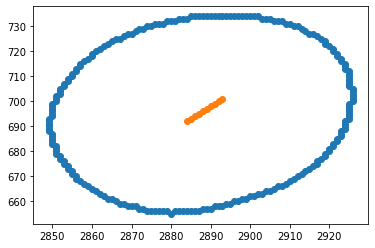

In [79]:
test=np.squeeze(contours[ii])
print(ii)
plt.scatter(test[:,0],test[:,1])
plt.scatter(hey[:,1],hey[:,0])


array([[2910,  672],
       [2913,  675],
       [2912,  674],
       [2911,  673]])

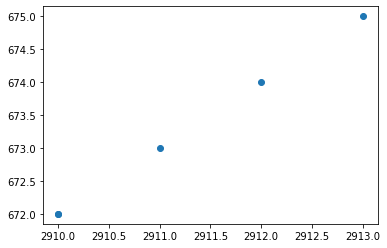

In [96]:
a=np.array([[2910,  672],[2913,  675],
 [2912,  674],
 [2911,  673],
 [2910,  672]])
plt.scatter(a[:,0],a[:,1])

indexes = np.unique(a, return_index=True,axis=0)[1]
np.squeeze([a[index] for index in sorted(indexes)])

In [189]:
# save data, there is probably a better way to do this, but I am not sure
d = {'Dipole': dipole_list, 'Elongation': elongation_list, 'Aspect_Ratio': aspect_ratio_list, 'Centroid_x':centroid_list[:,1] , 'Centroid_y': centroid_list[:,0], 'Diff_of_means': mean_m_list}
df = pd.DataFrame(data=d)
# name of the table
df.to_csv('exported_metrics_random_7_n.csv', index=False)
df

,Dipole,Elongation,Aspect_Ratio,Centroid_x,Centroid_y,Diff_of_means
0,0.051475,118.0,0.859223,3562,4141,0.095388
1,0.011128,21.0,0.927419,945,4094,0.098979
2,0.041194,45.0,0.952000,2577,4069,0.120777
3,0.056631,82.0,0.867089,3295,4050,0.127278
4,0.200725,212.0,0.758621,1055,4052,0.018169
...,...,...,...,...,...,...
100,0.056192,75.0,1.131387,3315,295,0.131589
101,0.185007,144.0,1.037433,1253,298,0.031139
102,0.036942,75.0,0.891026,2331,220,0.095375
103,0.139070,111.0,0.871795,1672,199,0.054188


# end of code bellow is just debugging / visualization stuff

C:\Users\heito\Desktop\Harvard\Sharad Lab\G1\Random_7


<ipython-input-190-9cae9ed9fda8>:31: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet"))
  cmap.set_bad(color = 'k', alpha = 1)


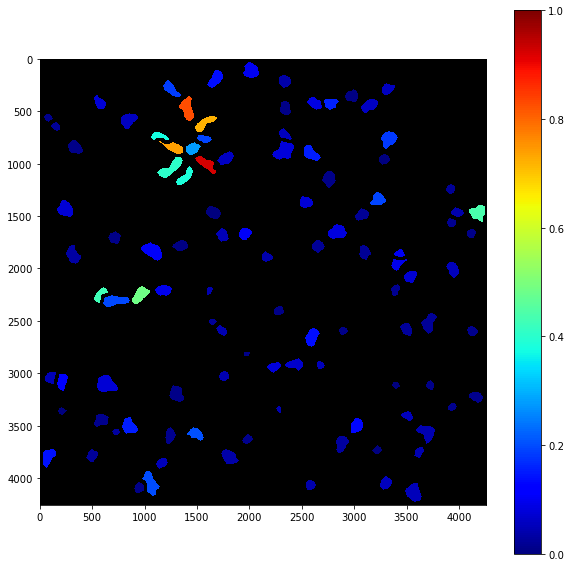

In [190]:
%cd C:\Users\heito\Desktop\Harvard\Sharad Lab\G1\Random_7 
img =cv2.imread('final_random_7_masks.tif') #segmented and eroded image (normally from DAPI stain)


# visualize dipole moment
df= pd.read_csv('exported_metrics_random_7_n.csv')
dipole_list=pd.DataFrame.to_numpy(df)[:,0]
# Grayscale8
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find Canny edges
edged = cv2.Canny(img, 30, 200)

#Find contours
contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

im_color=np.zeros( (img.shape[0],img.shape[1]) )

im_color[im_color==0]=np.nan
for ii in range(np.shape(dipole_list)[0]):
    
    
    im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image
    filled_array = cv2.fillPoly(im_zer, pts =[contours[ii]], color=(255))
        
    obj = np.argwhere(filled_array == 255)
    im_color[obj[:,0],obj[:,1]]=dipole_list[ii]
plt.figure(figsize=(10,10))

cmap = plt.cm.get_cmap("jet")
cmap.set_bad(color = 'k', alpha = 1)
im = plt.imshow(im_color, cmap=cmap,vmin=0, vmax=1)
im_color_4=im_color
plt.colorbar(im)




In [136]:
p2

array([0.67205882, 0.12563503, 0.9       , 0.46754679])

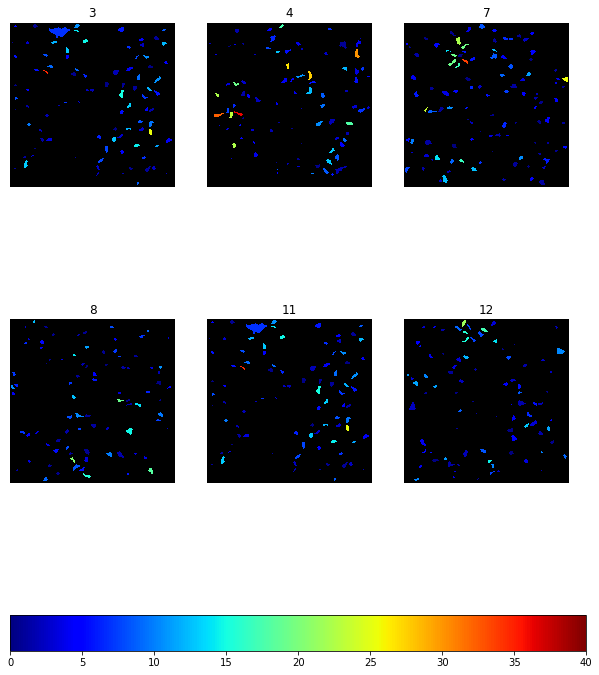

In [89]:

fig, axs = plt.subplots(2,3,figsize=(10,10))

axs[0,0].imshow(im_color_3, cmap = cmap,vmin=0, vmax=40)
axs[0,0].set_title("3")
axs[0,0].axis('off')
axs[0,1].imshow(im_color_4, cmap = cmap,vmin=0, vmax=40)
axs[0,1].set_title("4")
axs[0,1].axis('off')
im = axs[0,2].imshow(im_color_7, cmap = cmap,vmin=0, vmax=40)
axs[0,2].set_title("7")
axs[0,2].axis('off')
im = axs[1,0].imshow(im_color_8, cmap = cmap,vmin=0, vmax=40)
axs[1,0].set_title("8")
axs[1,0].axis('off')
im = axs[1,1].imshow(im_color_11, cmap = cmap,vmin=0, vmax=40)
axs[1,1].set_title("11")
axs[1,1].axis('off')
im = axs[1,2].imshow(im_color_12, cmap = cmap,vmin=0, vmax=40)
axs[1,2].set_title("12")
axs[1,2].axis('off')
p0 = axs[0,0].get_position().get_points().flatten()
p1 = axs[0,1].get_position().get_points().flatten()
p2 = axs[1,2].get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0], -0.05, 0.8, 0.05])
im= axs[1,2].imshow(im_color_12, cmap = cmap,vmin=0, vmax=40)
plt.colorbar(im, cax=ax_cbar, orientation='horizontal')


<ipython-input-9-6c82dc197039>:17: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet"))
  cmap.set_bad(color = 'k', alpha = 1)


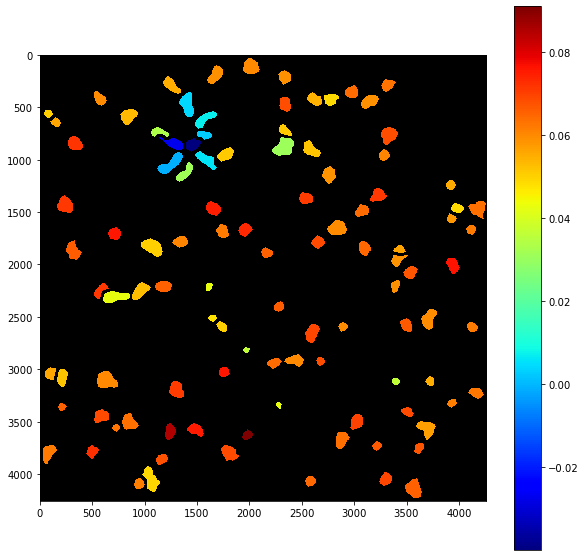

In [9]:
# visualize mean metric

im_color=np.zeros( (img.shape[0],img.shape[1]) )
 
im_color[im_color==0]=np.nan
for ii in range(np.shape(dipole_list)[0]):
    
    if true_org[ii]==1:
        im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image
        filled_array = cv2.fillPoly(im_zer, pts =[contours[ii]], color=(255))
        
        obj = np.argwhere(filled_array == 255)
        im_color[obj[:,0],obj[:,1]]=mean_m_list[ii]
plt.figure(figsize=(10,10))

cmap = plt.cm.get_cmap("jet")
cmap.set_bad(color = 'k', alpha = 1)
im = plt.imshow(im_color, cmap=cmap)

plt.colorbar(im)

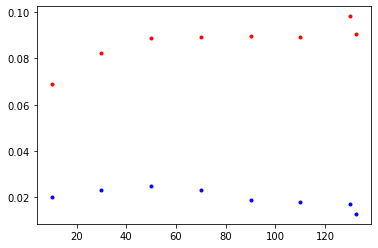

70.5

In [161]:
gene1=[0.06886484, 0.08211693, 0.08898413, 0.08910554, 0.08972873, 0.08920459,0.09819136, 0.09031054]
gene2=[0.02023379, 0.02307213, 0.02497011, 0.02308543, 0.0188759,  0.01797035, 0.01734052, 0.01285602]
pos=[ 10,   30,   50,   70,   90,  110,  130,  132.5]
plt.plot(pos,gene1,'r.')
plt.plot(pos,gene2,'b.')
plt.show()
np.shape(hey)[0]/2

In [ ]:
gene1=0
dip_1=gene1/np.max(gene1)*(position-np.shape(hey)[0]/2)
dip_2=gene2/np.max(gene2)*(position-np.shape(hey)[0]/2)    
dipole=np.abs(np.sum(dip_1)-np.sum(dip_2))/(np.shape(hey)[0]/2)

In [46]:
mean_m_list=np.empty([0,0])
[meanm]
mean_m_list=np.append(mean_m_list,meanm,axis=0)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 0 dimension(s)

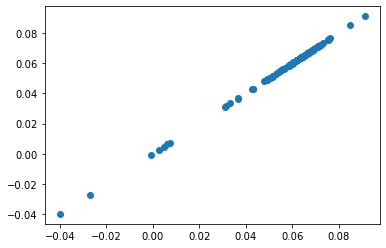

In [53]:
plt.scatter(mean_m_list,mean_m_list)
plt.show()

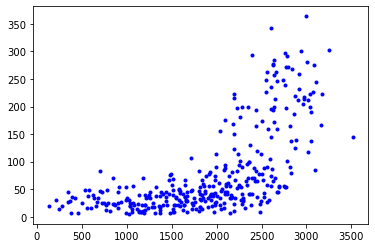

In [133]:
plt.plot(dist,elongation_list,'b.')

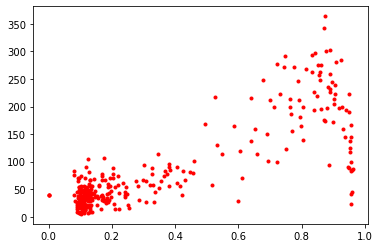

In [134]:
plt.plot(dipole_list,elongation_list,'r.')

(282.25, 6018.75, 267.75, 6257.25)

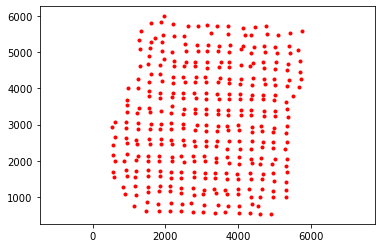

In [138]:
plt.plot(centroid_list[:,1],centroid_list[:,0],'r.')
plt.axis('equal')